# Dog/Cat Convolutional Classificator with TensorFlow

## Импорт библиотек

In [1]:
from google.colab import drive
import shutil
import zipfile
import os
import pathlib
from PIL import Image
import tensorflow as tf
import numpy as np
from tensorflow import keras
from matplotlib import pyplot as plt

tf.test.gpu_device_name()

'/device:GPU:0'

## Подключение GoogleDrive (Для Google Colab)

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


## Загрузка набора данных из GoogleDrive

In [3]:
zip_file_path = '/content/drive/MyDrive/Datasets/DogsVsCats.zip'
shutil.copy(zip_file_path, '/content/')

unzip_dir = '/content/DogsVsCats/'
with zipfile.ZipFile('/content/DogsVsCats.zip', 'r') as zip_ref:
    zip_ref.extractall(unzip_dir)

print(os.listdir(unzip_dir))

['MSR-LA - 3467.docx', 'readme[1].txt', 'PetImages']


## Валидация и разбиение данных

In [4]:
def check_images(directory):
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.endswith('.jpg'):
                filepath = os.path.join(root, file)
                try:
                    img_raw = tf.io.read_file(filepath)
                    img = tf.io.decode_image(img_raw, channels=3)
                    img_jpeg = tf.io.encode_jpeg(tf.cast(img, tf.uint8))
                except (tf.errors.InvalidArgumentError, ValueError) as e:
                    print(f"Ошибка с изображением {filepath}: {e}")
                    os.remove(filepath)  # Удаление проблемного изображения


check_images(unzip_dir)

original_dir = pathlib.Path('/content/DogsVsCats')
new_base_dir = pathlib.Path('/content/DogsVsCats/preprocessed')


def is_image_valid(filepath):
    try:
        with Image.open(filepath) as img:
            img.verify()  # Проверка целостности изображения
            return True
    except (IOError, SyntaxError) as e:
        print(f'Ошибка: {filepath} - {e}')
        return False


def make_subset(subset_name, start_index, end_index):
    for category in ('Cat', 'Dog'):
        directory = new_base_dir / subset_name / category
        os.makedirs(directory, exist_ok=True)
        current_index = start_index
        count = 0

        while count < (end_index - start_index):
            filename = f'{current_index}.jpg'
            src = original_dir / category / filename
            if is_image_valid(src):
                dst = directory / filename
                shutil.copyfile(src, dst)
                count += 1
            current_index += 1


make_subset('train', start_index=0, end_index=1000)
make_subset('validation', start_index=1000, end_index=1500)
make_subset('test', start_index=1500, end_index=2500)

Выходные данные были обрезаны до нескольких последних строк (5000).
Ошибка: /content/DogsVsCats/Cat/23030.jpg - [Errno 2] No such file or directory: '/content/DogsVsCats/Cat/23030.jpg'
Ошибка: /content/DogsVsCats/Cat/23031.jpg - [Errno 2] No such file or directory: '/content/DogsVsCats/Cat/23031.jpg'
Ошибка: /content/DogsVsCats/Cat/23032.jpg - [Errno 2] No such file or directory: '/content/DogsVsCats/Cat/23032.jpg'
Ошибка: /content/DogsVsCats/Cat/23033.jpg - [Errno 2] No such file or directory: '/content/DogsVsCats/Cat/23033.jpg'
Ошибка: /content/DogsVsCats/Cat/23034.jpg - [Errno 2] No such file or directory: '/content/DogsVsCats/Cat/23034.jpg'
Ошибка: /content/DogsVsCats/Cat/23035.jpg - [Errno 2] No such file or directory: '/content/DogsVsCats/Cat/23035.jpg'
Ошибка: /content/DogsVsCats/Cat/23036.jpg - [Errno 2] No such file or directory: '/content/DogsVsCats/Cat/23036.jpg'
Ошибка: /content/DogsVsCats/Cat/23037.jpg - [Errno 2] No such file or directory: '/content/DogsVsCats/Cat/23037.j

KeyboardInterrupt: 

## Построение модели

Модель будет дообучаться на модели VGG16, обученной на основе набора данных ImageNet.

In [ ]:
conv_base = keras.applications.vgg16.VGG16(
    weights='imagenet',
    include_top=False,
    input_shape=(180, 180, 3)
)

conv_base.trainable = False  # Заморозка ранее обученных весов

data_augmentation = keras.Sequential([
    keras.layers.RandomFlip('horizontal'),
    keras.layers.RandomRotation(0.1),
    keras.layers.RandomZoom(0.2)
])

inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = keras.applications.vgg16.preprocess_input(x)
x = conv_base(x)
x = keras.layers.Flatten()(x)
x = keras.layers.Dense(256)(x)
x = keras.layers.Dropout(0.5)(x)
outputs = keras.layers.Dense(1, activation='sigmoid')(x)
model = keras.Model(inputs, outputs)

model.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 19s 0us/step


Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 180, 180, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 180, 180, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 90, 90, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 90, 90, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 90, 90, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 45, 45, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 45, 45, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 45, 45, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 45, 45, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 22, 22, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 22, 22, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 22, 22, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 22, 22, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 11, 11, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 11, 11, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 11, 11, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 11, 11, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 5, 5, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 5, 5, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     3,277,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,277,313 (12.50 MB)

 Trainable params: 3,277,313 (12.50 MB)

 Non-trainable params: 0 (0.00 B)

На этапе компиляции используем стандартный оптимизатор `RMSprop`. Так как модель заканчивается единственным сигмоидным выходом, используем функцию потерь `binary_crossentropy`.

In [ ]:
model.compile(
    loss='binary_crossentropy',
    optimizer='rmsprop',
    metrics=['accuracy']
)

## Загрузка данных

Для загрузки данных воспользуемся встроенной в Keras функцией `image_dataset_from_directory()`, которая позволит быстро настроить конвейер обработки для автоматического преобразования файлов с изображениями в пакеты готовых тензоров.

In [ ]:
train_dataset = keras.utils.image_dataset_from_directory(
    '/content/DogsVsCats/preprocessed/train',
    image_size=(180, 180),
    batch_size=32
)
validation_dataset = keras.utils.image_dataset_from_directory(
    '/content/DogsVsCats/preprocessed/validation',
    image_size=(180, 180),
    batch_size=32
)
test_dataset = keras.utils.image_dataset_from_directory(
    '/content/DogsVsCats/preprocessed/test',
    image_size=(180, 180),
    batch_size=32
)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━

## Обучение модели с выделением признаков

Создадим обратный вызов, чтобы автоматически остановить обучение и сохранить лучший вариант модели. Далее обучим модель на ранее подготовленных данных.

In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath='/content/dogsvscats.keras',
        save_best_only=True,
        monitor='val_loss'
    ),
    keras.callbacks.EarlyStopping(
        monitor='val_accuracy',
		patience=10
    )
]

history = model.fit(
    train_dataset,
    epochs=50,
    validation_data=validation_dataset,
    callbacks=callbacks
)

Epoch 1/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - accuracy: 0.8739 - loss: 25.9644 - val_accuracy: 0.9540 - val_loss: 6.8615
Epoch 2/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.9779 - loss: 2.7044 - val_accuracy: 0.9660 - val_loss: 5.8196
Epoch 3/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.9834 - loss: 2.2800 - val_accuracy: 0.9760 - val_loss: 4.1895
Epoch 4/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.9895 - loss: 1.6252 - val_accuracy: 0.9730 - val_loss: 4.2818
Epoch 5/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.9964 - loss: 0.3992 - val_accuracy: 0.9730 - val_loss: 5.7216
Epoch 6/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.9941 - loss: 1.2827 - val_accuracy: 0.9740 - val_loss: 4.5128
Epoch 7/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.9963 - loss: 0.5690 - val_accuracy: 0.9750 - val_loss: 4.1141
Epoch 8/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.9963 - loss: 0.6786 - val_accuracy: 0.9640 - 

## Визуализация обучения с выделением признаков

Построим графики изменения потерь и точности в процессе обучения модели.

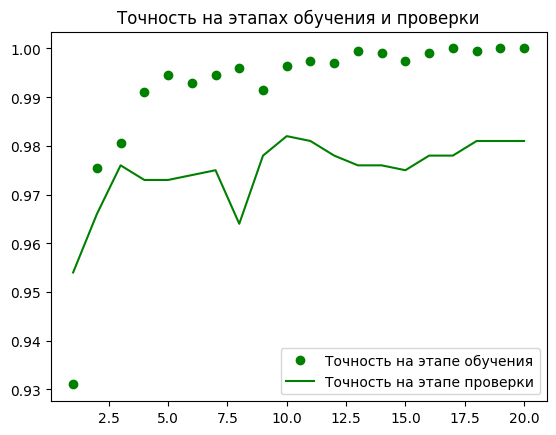

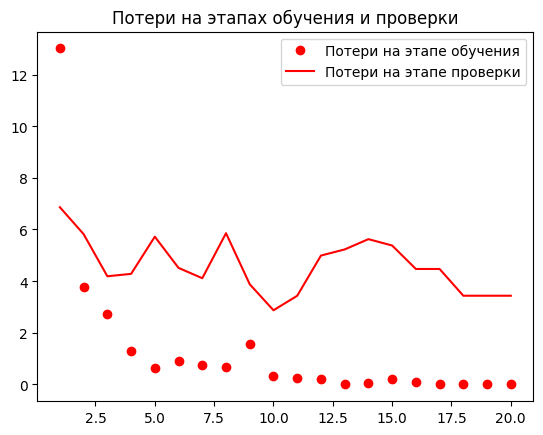

In [ ]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, 'go', label='Точность на этапе обучения')
plt.plot(epochs, val_accuracy, 'g', label='Точность на этапе проверки')
plt.title('Точность на этапах обучения и проверки')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'ro', label='Потери на этапе обучения')
plt.plot(epochs, val_loss, 'r', label='Потери на этапе проверки')
plt.title('Потери на этапах обучения и проверки')
plt.legend()
plt.show()

## Дообучение с заморозкой определенных весов

In [ ]:
conv_base.trainable = True
for layer in conv_base.layers[:-4]:
	layer.trainable = False

model.compile(
	loss='binary_crossentropy',
	optimizer=keras.optimizers.RMSprop(learning_rate=1e-5),  # Низкая скорость обучения
	metrics=['accuracy']
)

history = model.fit(
    train_dataset,
	epochs=30,
	validation_data=validation_dataset,
	callbacks=callbacks
)

Epoch 1/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - accuracy: 0.9988 - loss: 0.0345 - val_accuracy: 0.9810 - val_loss: 3.4417
Epoch 2/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 0.9810 - val_loss: 3.4417
Epoch 3/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.9996 - loss: 0.0177 - val_accuracy: 0.9810 - val_loss: 3.4367
Epoch 4/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.9997 - loss: 0.0060 - val_accuracy: 0.9810 - val_loss: 3.4342
Epoch 5/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.9991 - loss: 0.0839 - val_accuracy: 0.9810 - val_loss: 3.4259
Epoch 6/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 0.9810 - val_loss: 3.4259
Epoch 7/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.9989 - loss: 0.1165 - val_accuracy: 0.9810 - val_loss: 3.4279
Epoch 8/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.9999 - loss: 0.0067 - val_accuracy: 0.

## Тестирование модели

In [ ]:
test_model = keras.models.load_model('../models/dogsvscats.keras')
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f'Test accuracy: {test_acc:.3f}')

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9728 - loss: 6.3812
Test accuracy: 0.974
